In [1]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import words, stopwords
from tqdm import tqdm
from collections import defaultdict
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pickle
import spacy
from sklearn.cluster import KMeans

# Extract Co-Occurrence Data
Here, we find (in three steps) the number of times each pair of names is mentioned within some window of each other in the text. We analyse this data in more detail (using SVD and graph centrality) in later sections.

## Occurrences of Names
The following code extracts, for each occurrence of a name in the text, the index of its position in the text. This allows us to quickly compute the number of times two names co-occur in the text.

The model we use for NER (named entity recognition) tends to recognize people's names as either `PERSON` or `ORG`. We filter for these categories. We then manually generate the `people.txt` file by removing place names, etc. and mapping together names that refer to the same person.

In [2]:
nlp = spacy.load('en_core_web_sm')
with open('humayunnama.txt', 'r') as f:
    doc = nlp(f.read())

occurrences = {}
for ent in doc.ents:
    #if ent.text == "Muḥammad Akbar": print(ent)
    try:
        occurrences[ent.text].append((ent.start_char, ent.end_char))
    except KeyError:
        occurrences[ent.text] = [(ent.start_char, ent.end_char)]
    #if ent.text == "Muḥammad Akbar": print(occurrences["Muḥammad Akbar"])

with open('names.txt', 'w') as f:
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'ORG']:
            f.write(ent.text + "\n")

## Accounting for Titles, etc.
The file `people.txt` contains a list of the names of people occurring on the text – one person per line. For people with multiple names (e.g. *Mīrzā Bābar* and *Firdaus-makānī*), the alternatives are separated by semicolons `;`.

The occurrence list is modified to use only one name per person (the first name in the line for that person).

In [3]:
try:
    with open('people.txt', 'r') as f:
        print("Found people.txt, using.")
        all_names = []
        names = []
        mapping = {}
        for line in f:
            n = line[:-1].split(';')
            all_names += n
            names.append(n[0])
            if len(n) > 1:
                for name in n[1:]:
                    mapping[name] = n[0]
        
    for name in all_names:
        if name in mapping:
            #print(f"Shifting {name} to {mapping[name]}")
            occurrences[mapping[name]] += occurrences[name]
            del occurrences[name]
            

except FileNotFoundError:
    names = list(occurrences.keys())
    with open('names.txt', 'r') as f:
        for name in names: f.write(f"{name}\n")
    print("Using names including non-people!")

Found people.txt, using.


## Counting Co-Occurrence
Now, we consider all possible pairs of people, and count how many times their names occur within 5 words of each other (this is our window size).

We check for the number of spaces between the words.

In [4]:
try:
    cooccurrence = defaultdict(lambda : 0)
    with open('cooccurrence.txt', 'r') as f:
        print("Found cooccurrence.txt, using.")
        for line in f:
            n1, n2, x = line[:-1].split(';')
            cooccurrence[(n1, n2)] = int(x)
except:
    with open('humayunnama.txt', 'r') as f:
        text = f.read()

    W = 7
    cooccurrence = defaultdict(lambda : 0)
    for i in tqdm(range(len(names)), desc="Extracting cooccurrences"):
        name1 = names[i]
        positions1 = occurrences[name1]
        for name2 in names[:i] + names[i+1:]:
            positions2 = occurrences[name2]
            distances = [text[e1:b2].count(' ') if b1 < b2 else text[e2:b1].count(' ') for b1, e1 in positions1 for b2, e2 in positions2]
            cooccurrence[(name1, name2)] = sum(1 for d in distances if d <= W)

    with open('cooccurrence.txt', 'w') as f:
        for k in cooccurrence:
            n1, n2 = k
            f.write(f'{n1};{n2};{cooccurrence[k]}' + '\n')

Found cooccurrence.txt, using.


# SVD-Based Embeddings
We now consider the matrix of co-occurrence data, with the entry at row $r$ and column $c$ representing the number of times the $r^\text{th}$ and $c^\text{th}$ names co-occur.

This matrix can be thought to contain all the information about the relationships between the characters that their relative positions in the text can provide. We use a mathematical technique, SVD (singular value decomposition) to *compress* this matrix into a smaller one. In this new matrix, each row corresponds to a single person and is a vector of 150 numbers. This vector is called an *embedding* of the person, and its geometric properties (*e.g.* distance from other vectors) are meant to encode information about the person themself.

This is a common technique for associating words with vectors, which is a fundamental part of modern NLP systems. Although this is an outdated method for this, it's the only one applicable in the scale of data available. For an overview of how this is done, [this article](https://medium.com/analytics-vidhya/co-occurrence-matrix-singular-value-decomposition-svd-31b3d3deb305) provides a deeper explanation.

In [5]:
n = len(names)
adjacency = np.zeros((n, n), dtype=int)
for i in range(n):
    for j in range(n):
        val = 0
        val += cooccurrence[(names[i], names[j])] if (names[i], names[j]) in cooccurrence else 0
        val += cooccurrence[(names[j], names[i])] if (names[j], names[i]) in cooccurrence else 0
        adjacency[i, j] = adjacency[j, i] = val

u, s, vh = np.linalg.svd(adjacency)
print("Information content:", sum(s[:150])/sum(s)) # ~ 0.89
embeddings = u[:, :150]
norms = np.linalg.norm(embeddings, axis=-1, keepdims=True)
norms[norms == 0] = 1
embeddings = embeddings / norms

Information content: 0.8928331232622666


We find the distances between each pair of people using these embeddings.

/opt/homebrew/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 61699 (\uf103) missing from current font.
  fig.canvas.draw()


<Axes: >

/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 61699 (\uf103) missing from current font.
  func(*args, **kwargs)
/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 61699 (\uf103) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


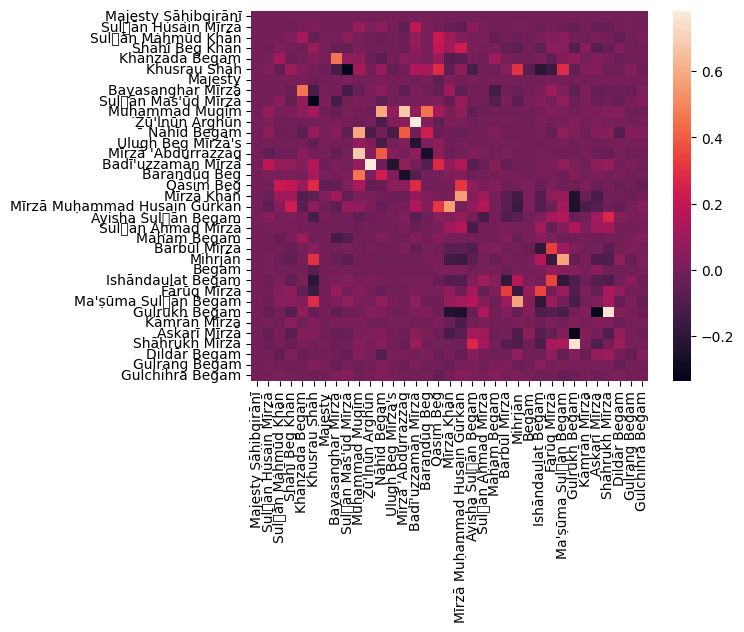

In [6]:
distances = embeddings @ embeddings.transpose()
np.fill_diagonal(distances, 0)
L = 35
seaborn.heatmap(distances[:L, :L], xticklabels=names[:L], yticklabels=names[:L])

We use a graph to determine the nature of the embedding space. We end up with several (21) components – the largest is a cluster of 15 names, the next two have 4 names each, the next four have three names each, and the remaining are isolated pairs.

This makes it seem like a clustering algorithm is a good way to go here.
We end up with 8 clusters.

In [7]:
#related = np.transpose((distances > 0.8).nonzero())
#close = nx.Graph()
#close.add_nodes_from([names[i] for i in range(len(names)) if i in related[:, 0]])
#close.add_edges_from([(names[i], names[j]) for i, j in related if i != j])
#components = [close.subgraph(c).copy() for c in sorted(nx.connected_components(close), key=len, reverse=True)]
#print(len(components))
#print([len(component) for component in components])
#nx.draw(components[7], nx.spring_layout(components[7]), node_size=2, with_labels=True, font_size=10)
#plt.show()

clustering = KMeans(n_clusters=50)
clustering.fit(embeddings)
clusters = clustering.labels_
for i in range(clusters.max()):
    print(f"\n{i}")
    for n in (clusters == i).nonzero()[0]: print(names[n], end=", ")

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



0
Rāja Māldeo, Ghaznī, Zāhid Beg, 
1
Qāsim Beg, Nāṣir Mīrzā, Khwāja Qāsim, Rānā Sangā, Muḥammad, Mīr Zāycha, Mihrangez Begam, Jahāngīr Beg, Nūr Beg, Bahlūl, Mū'yid Beg, Mullā, Sulān Qulī, Mīrzā Muḥammad Akbar, Khwāja Dost Khāwand, 
2
Tūkhtābūghā Sulān, Sulān Begam, Qarā Khān's, 
3
Qāsim Ḥusain Sulān,—a, Āyisha Sulān, Bachaka, 
4
Alī Karīmullāh, 
5
Isāntīmūr Sulān, 
6
Khwāja Kilān Beg, Khawāṣ Khān, Qāsim (Ḥusain Sulān Uzbeg, Salīm Shāh, 
7
Mahdī Khwāja, Bihbūd, Ranī, Uncle, 
8
Mīrzā Bābar, Jalāluddīn Muḥammad Akbar, Jūkī Khān, Tarkhān Bega, 
9
Faīma Sulān, 
10
Mīr Faqr'ali Beg, Mīrzā, 
11
Bega, Sa'ādat Sulān, 
12
Mīrzā Ḥaidar, Bakhshībānū, Mīrzā Ḥaidar, 
13
Muaffar Beg, Bābā Dashtī, Muḥammad Alī, 
14
Jūkī, Ibrāhīm Sulān Mīrzā, Āq Sulān, 
15
Dostī, 
16
Majesty Ṣāḥibqirānī, Sulān Ḥusain Mīrzā, Sulān Maḥmūd Khān, Khānzāda Begam, Khusrau Shāh, Majesty, Bayasanghar Mīrzā, Sulān Mas'ūd Mīrzā, Ulugh Beg Mīrzā's, Barandūq Beg, Mīrzā Khān, Mīrzā Muḥammad Ḥusain Gūrkān, Āyisha Su

# Connection Graph
We can also use the co-occurrence matrix to construct a graph of the various people involved, treating the co-occurrence matrix as an *adjacency matrix* – two people have an edge connecting their names if they co-occur at least once.

## Constructing the Graph

In [8]:
# Collapse name1-name2 and name2-name1
for (n1, n2) in [(n1, n2) for n1 in names for n2 in names]:
    if (n1 <= n2): continue
    cooccurrence[(n2, n1)] += cooccurrence[(n1, n2)]
    del cooccurrence[(n1, n2)]

In [9]:
# Construct graph
G = nx.Graph()
G.add_nodes_from(names)
for (n1, n2) in cooccurrence:
    if cooccurrence[(n1, n2)] > 0:
        G.add_edge(n1, n2)

In [10]:
# Remove nodes without edges
for n in names:
    if len(G.edges(n)) == 0:
        G.remove_node(n)

This graph ends up being extremely disconnected – we ignore the outlying smaller graphs, and only consider the largest connected component.

/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 61699 (\uf103) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 61701 (\uf105) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


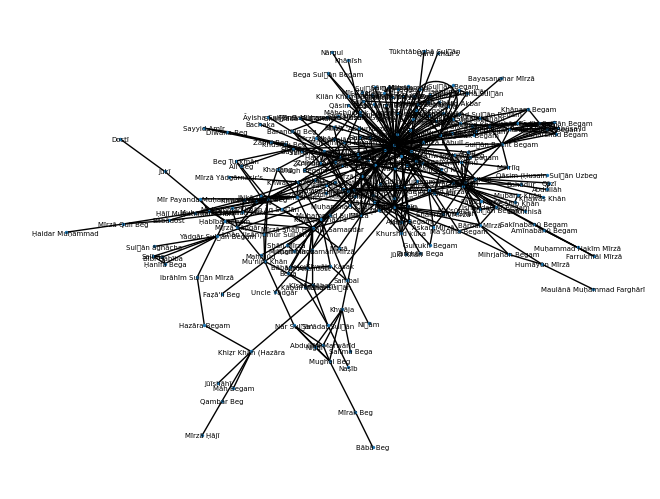

In [11]:
components = [G.subgraph(c).copy() for c in sorted(nx.connected_components(G), key=len, reverse=True)]

component = components[0]
nx.draw(component, nx.spring_layout(component), node_size=2, with_labels=True, font_size=5)
plt.show()

## Centrality
Since the graph appears extremely convoluted and hard to interpret, we consider certain mathematical attributes of the graph that may help us simplify it.

Node centrality computes, intuitively, how "influential" or "important" a certain node is. This concept comes from sociological studies – more information about their calculation and use can be found [on the Wiki page](https://en.wikipedia.org/wiki/Centrality).

We plot the centrality in descending order.

/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 61699 (\uf103) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 61701 (\uf105) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


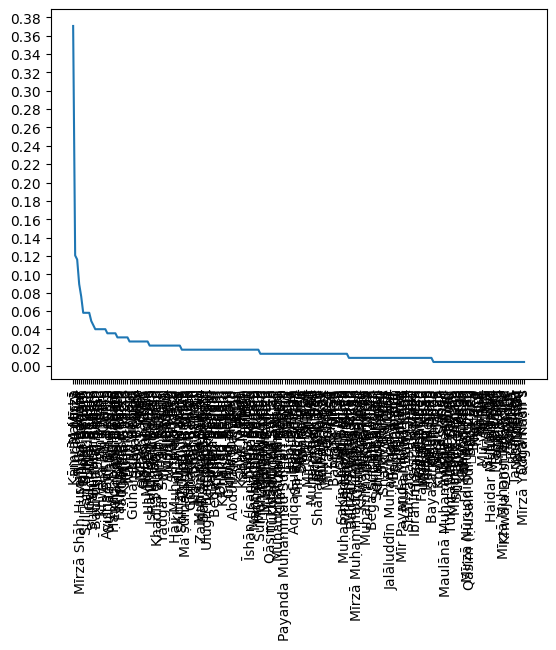

In [12]:
centrality = nx.degree_centrality(component)
centrality = sorted(centrality.items(), key = lambda p : p[1], reverse=True)
plt.plot(range(len(centrality)), [c for _, c in centrality])
plt.xticks(range(len(centrality)), [n for n, __ in centrality], rotation=90)
plt.yticks([i/50 for i in range(20)])
plt.show()

In [13]:
for n, _ in centrality: print(n)

Majesty
Kāmrān Mīrzā
Hindāl Mīrzā
Begam
Mīrzā Shāh Ḥusain Samandar
Māham Begam
Dildār Begam
Sulān Bakht Begam
Nadīm Beg
Gulchihra Begam
Sulān Ḥusain Mīrzā
Gulrang Begam
Badī'uljamāl Begam
Mīrzā '
Shīr Khān
Khwāja Mu'aam
Bairām Khān's
Āyisha Sulān Begam
Sulān Aḥmad Mīrzā
Āq Begam
Sulānam
Ḥamīdabānū Begam
Khānzāda Begam
Bārbūl Mīrzā
Fakhrjahān Begam
Yādgārnāṣir Mīrzā
Khwāja Ghāzī's
Mu'nim Khān
Nāhīd Begam
Mihrjān
Gūharshād Begam
Alwar Mīrzā
Bega Begam
Amīr
Mīrzā Yādgār
Qarācha Khān
Raushan kūka
Mīrzā Sulaimān
Ulugh Beg Mīrzā's
Ishāndaulat Begam
Fārūq Mīrzā
Sulān Abūsa'īd
Khadīja Sulān Begam
Zainab Sulān
Khalīfa
Yādgār Sulān Begam
Mihrbānū
Alūsh Begam
Mughal Beg
Zahīd Beg
Khwāja Nīāzī
Ḥājī Muḥammad Khān
Khwāja
Khiẓr Khān (Hazāra
Sulān Mas'ūd Mīrzā
Ẕū'lnūn Arghūn
Ma'ṣūma Sulān Begam
Askarī Mīrzā
Shāhrukh Mīrzā
Gulbadan Begam
Shāh Ismā'īl
Ma'ṣūma Begam
Maywajān
Muḥammad Sulān
Zainab Sulān Begam
Sulān Khalīl Mīrzā
Begī Begam
Ulugh Beg Mīrzā Kābulī
Shāh Khānam
Khānam Begam
Mīr

It is natural then to ask – can we determine centrality from information specific to the person? For example, does centrality correspond to the distance of a person from Humayun?

We plot the distance from Humayun on top of the centrality for each person – this reveals no such correlation.

In [14]:
print([(i, c) for i, (n, c) in enumerate(centrality) if n == "Khānzāda Begam"])

[(22, 0.03125)]


ValueError: "Mīrzā Yādgārnāṣir's" is not in list

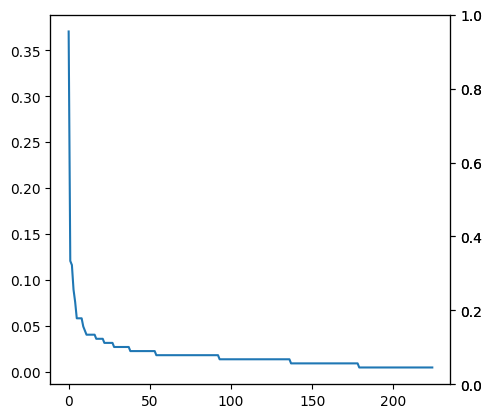

In [15]:
# Is centrality corresponding to distance from Humayun?

fig, ax1 = plt.subplots()
fig.subplots_adjust(right=0.75)
ax2 = ax1.twinx()
ax3 = ax1.twinx()

p1, = ax1.plot(range(len(centrality)), [c for _, c in centrality], "C0", label="Centrality")
p2, = ax2.plot(range(len(centrality)), [distances[1, names.index(n)] for n, _ in centrality], "C1", label="H. Distance")
p3, = ax3.plot(range(len(centrality)), [1/i for i in range(1, len(centrality)+1)], "C2", label="1/x")

ax1.set(ylim=(0, 0.4), ylabel="Centrality")
ax2.set(ylim=(-1, 1), ylabel="H. Distance")
ax3.set(ylim=(0, 0.4), ylabel="Zipf's Law")

ax1.legend(handles=[p1, p2, p3])

## Subgraphs
As the large graph is unreadable, we consider a smaller graph consisting of the names which have the highest centrality (above 0.03).

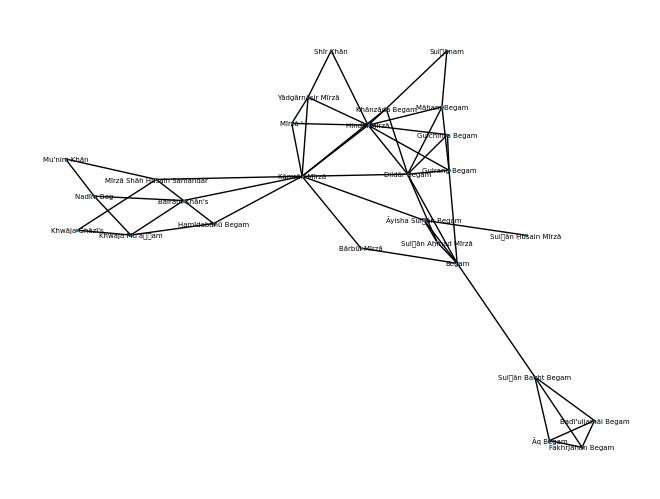

In [16]:
t = 0.03
central_names = [name for name, c in centrality if c >= t][1:] # remove "Majesty"; 27 names
main_names = nx.Graph.subgraph(component, central_names)
nx.draw(main_names, nx.spring_layout(main_names), node_size=2, with_labels=True, font_size=5)
plt.show()

We have therefore been able to quantify the "importance" of a character in a way that corresponds to our intuition. Now, we can examine the distance data that we obtained above in the context of the most important characters.

First, we note that the great majority of the similarities ($88815/303^2 \approx 97\%$) are between -0.2 and 0.2. This suggests that we ought to consider the pairs outside this range as points of interest.

Thus, for each of the names that have centrality above our threshold (0.03), we consider the set of names that lie outside this range of similarities from them.

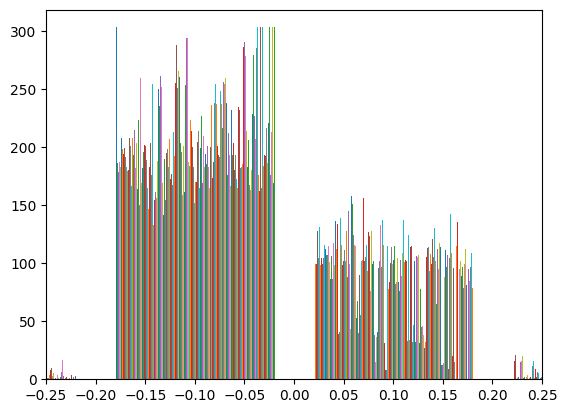

88815

In [89]:
plt.hist(distances)
plt.xlim(-0.25, 0.25)
plt.xticks(np.linspace(-0.25, 0.25, 11))
plt.show()
((distances > -0.2) & (distances < 0.2)).nonzero()[0].size

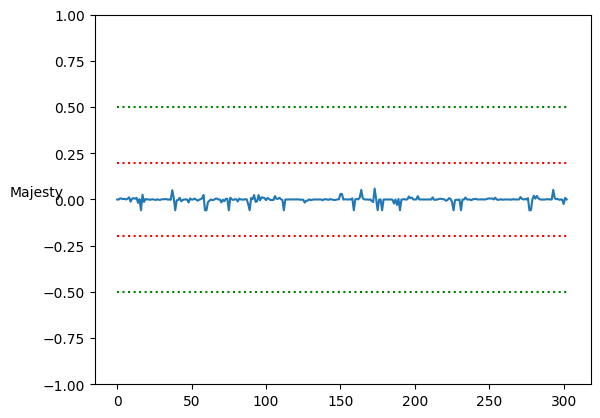

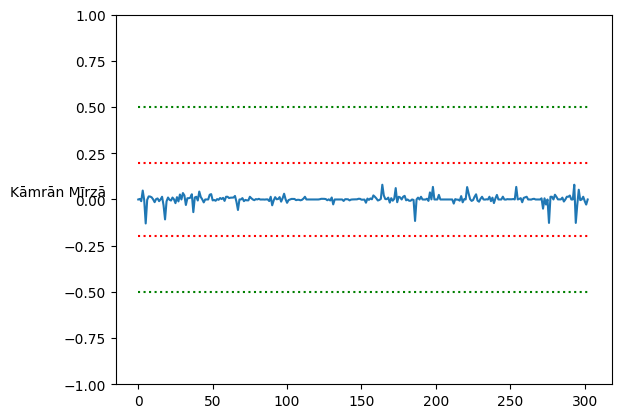

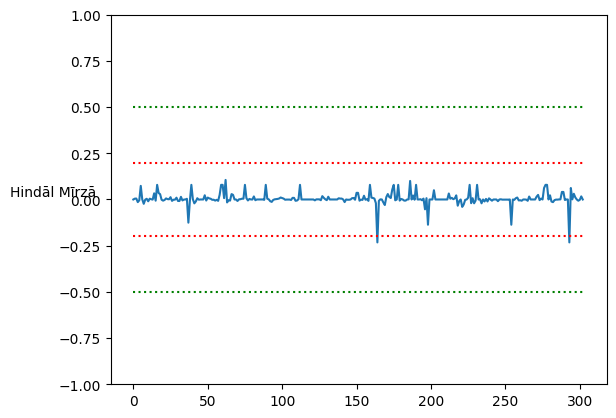

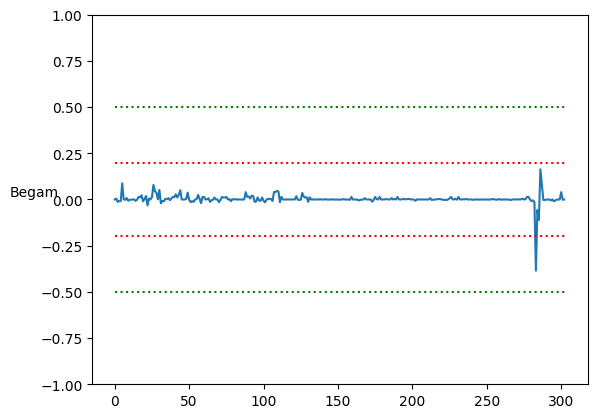

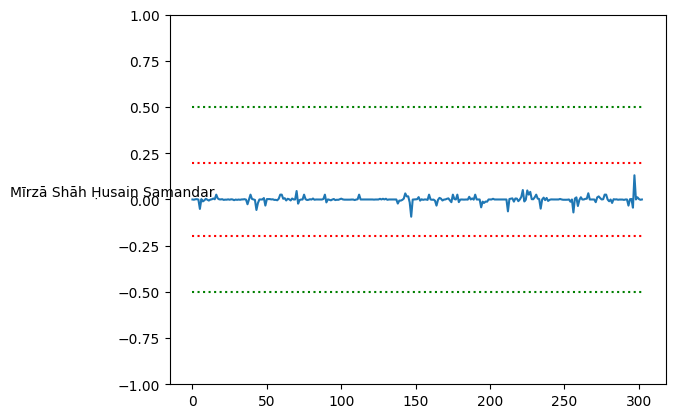

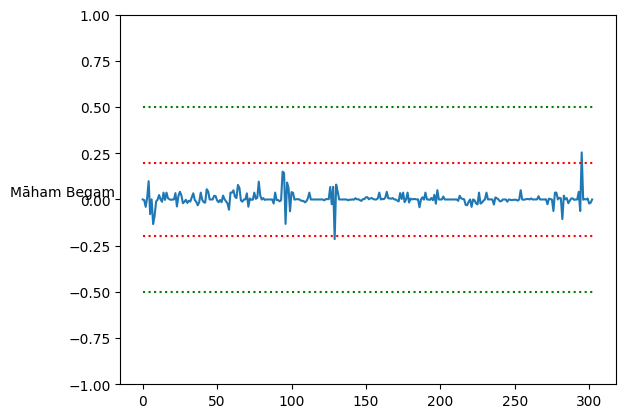

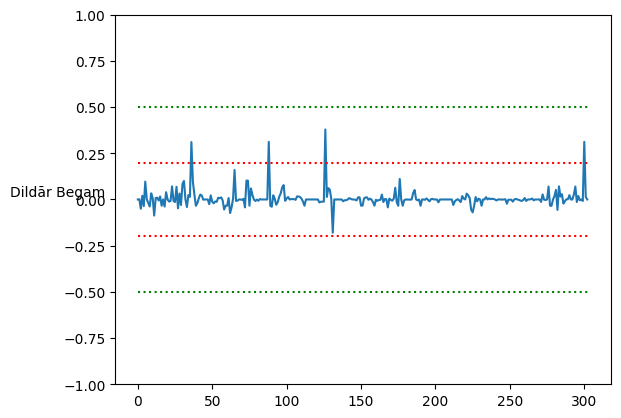

/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 61699 (\uf103) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


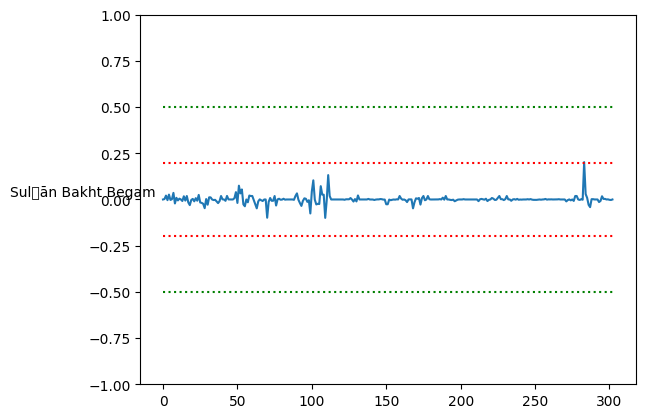

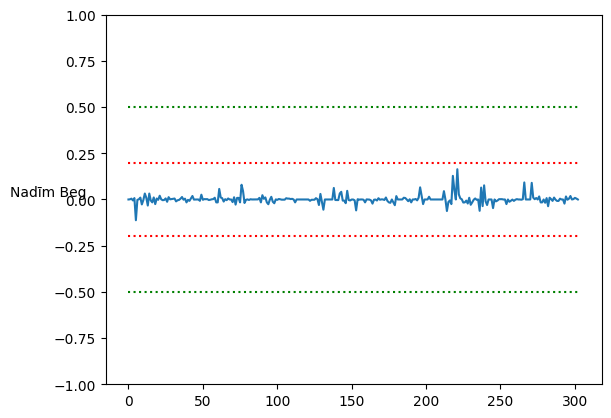

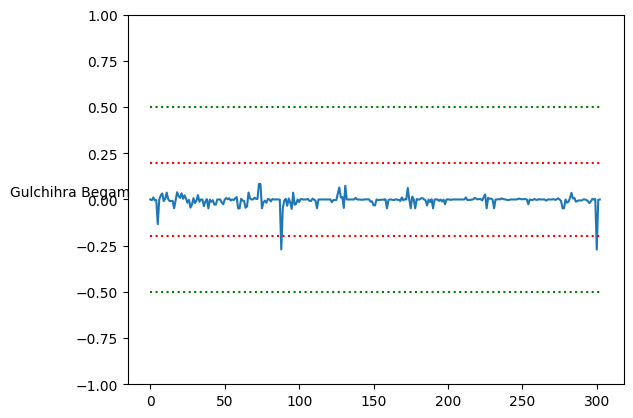

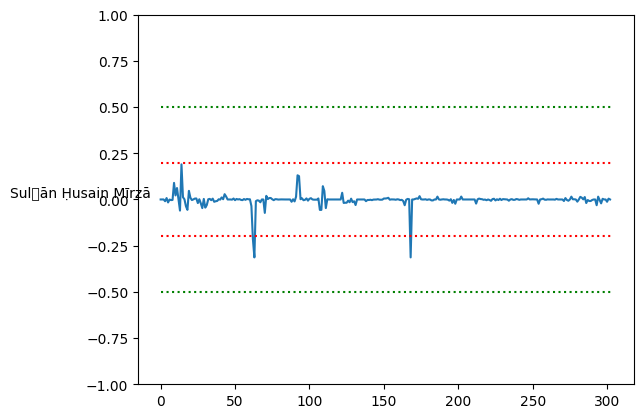

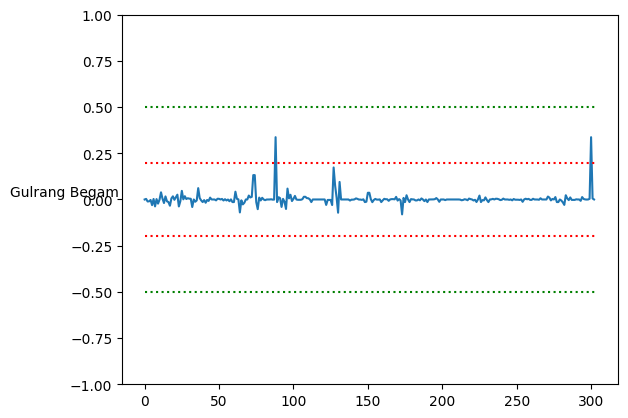

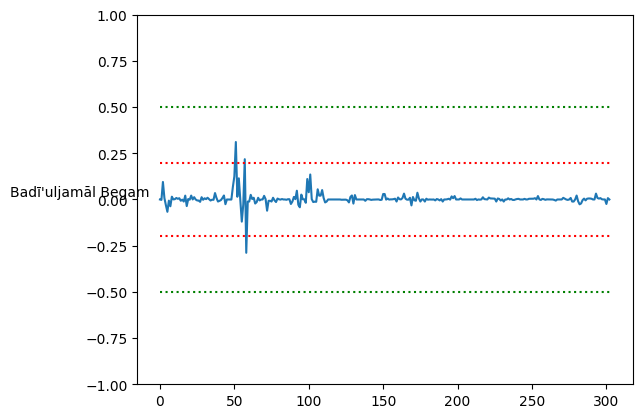

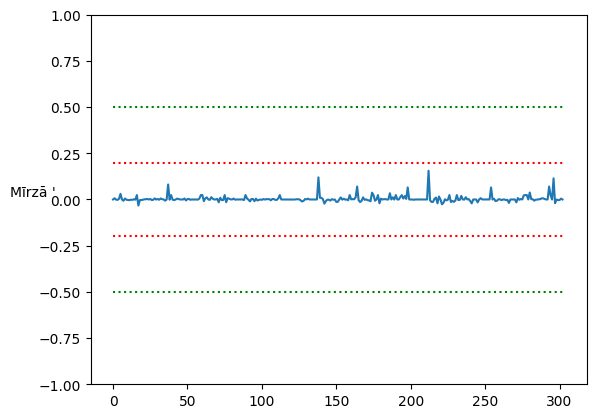

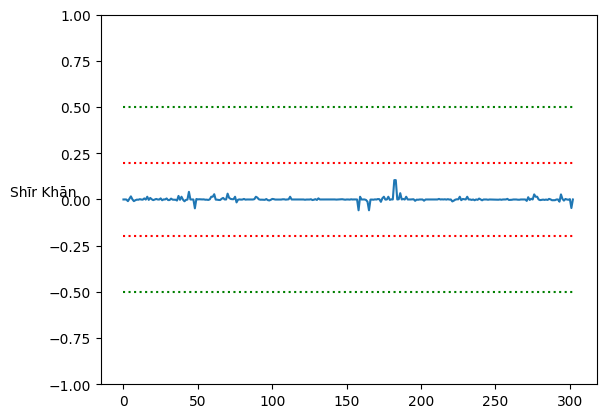

/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 61701 (\uf105) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


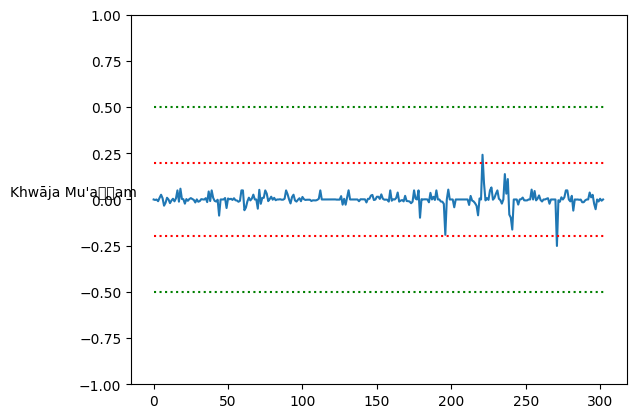

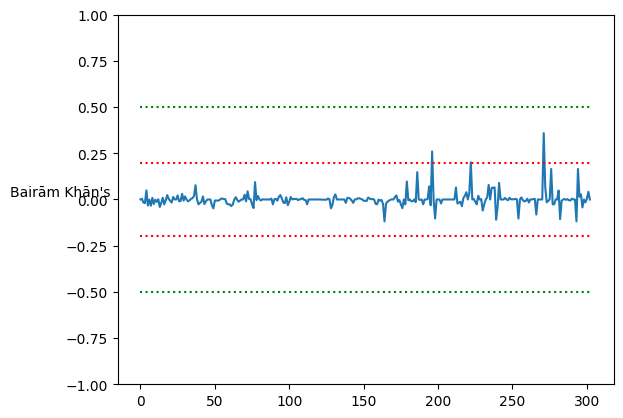

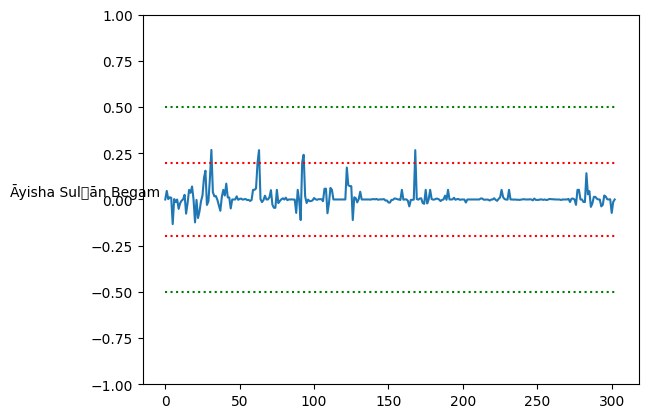

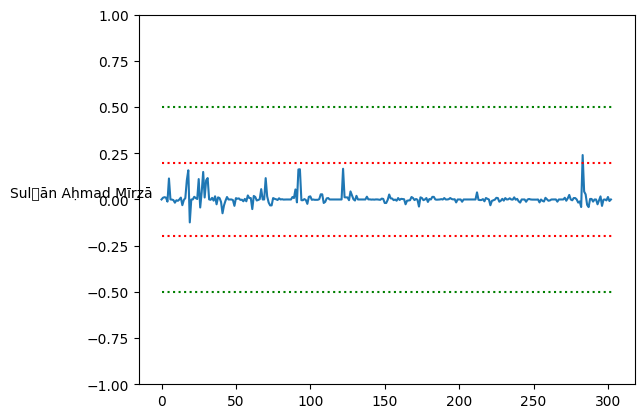

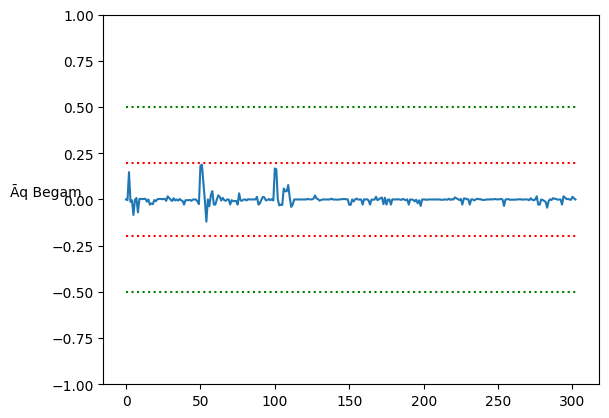

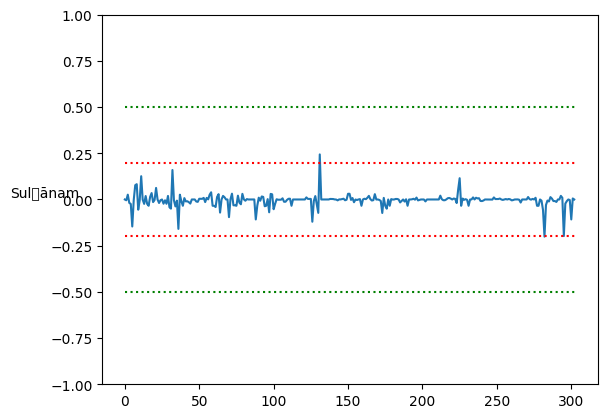

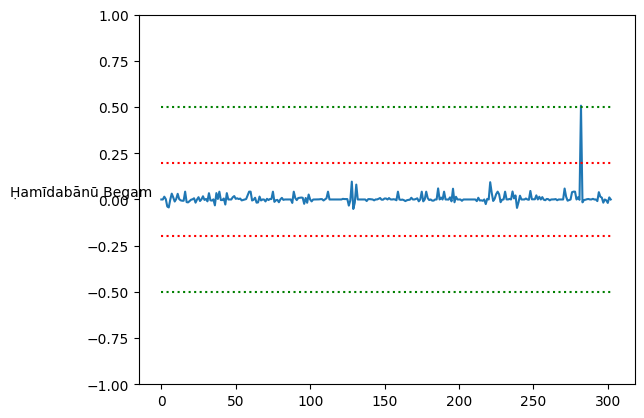

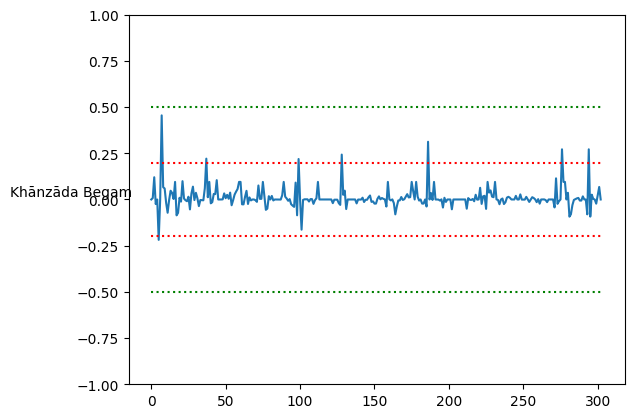

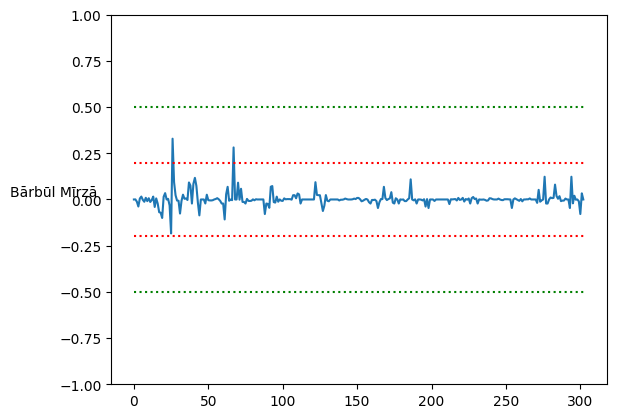

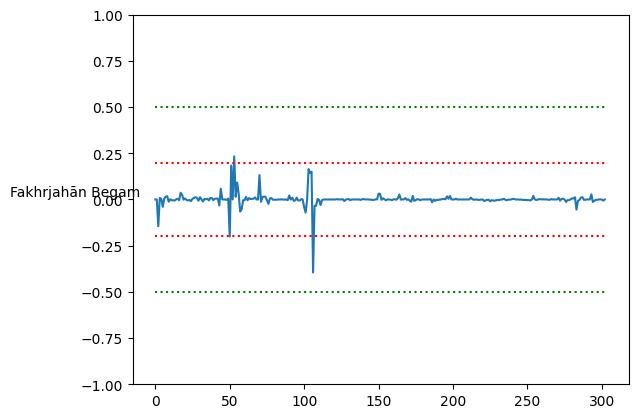

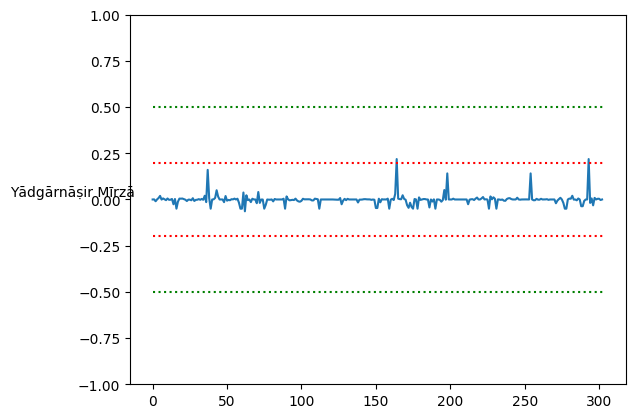

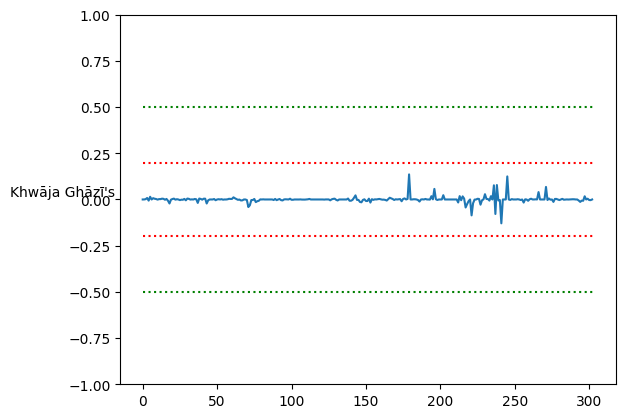

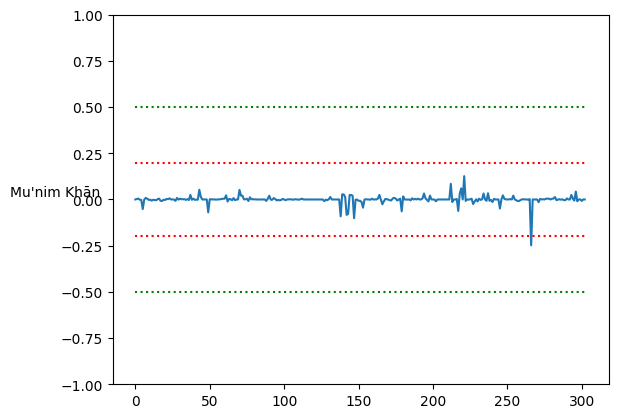

In [44]:
for name in central_names:
    i = names.index(name)
    plt.plot(range(len(names)), distances[i])
    plt.ylabel(f"{name}", rotation="horizontal")
    plt.ylim(-1, 1)
    plt.hlines([0.2, -0.2, 0.5, -0.5], xmin=0, xmax=303, colors=['red', 'red', 'green', 'green'], linestyles='dotted')
    plt.show()

In [66]:
for name in central_names:
    i = names.index(name)
    peaks = (distances[i] > 0.2).nonzero()[0]
    print(name, ">  0.2 ->", [names[j] for j in peaks])
    peaks = (distances[i] < -0.2).nonzero()[0]
    print(name, "< -0.2 ->", [names[j] for j in peaks])
    print()

Majesty >  0.2 -> []
Majesty < -0.2 -> []

Kāmrān Mīrzā >  0.2 -> []
Kāmrān Mīrzā < -0.2 -> []

Hindāl Mīrzā >  0.2 -> []
Hindāl Mīrzā < -0.2 -> ['Mīrzā Nūruddīn Muḥammad', 'Āskarī']

Begam >  0.2 -> []
Begam < -0.2 -> ['Bakhtnisā']

Mīrzā Shāh Ḥusain Samandar >  0.2 -> []
Mīrzā Shāh Ḥusain Samandar < -0.2 -> []

Māham Begam >  0.2 -> ['Ḥaram Begam']
Māham Begam < -0.2 -> ['Amīr']

Dildār Begam >  0.2 -> ['Gulbadan Begam', 'Tūkhtābūghā Sul\uf103ān', 'Sul\uf103ān Begam', "Qarā Khān's"]
Dildār Begam < -0.2 -> []

Sulān Bakht Begam >  0.2 -> ['Bakhtnisā']
Sulān Bakht Begam < -0.2 -> []

Nadīm Beg >  0.2 -> []
Nadīm Beg < -0.2 -> []

Gulchihra Begam >  0.2 -> []
Gulchihra Begam < -0.2 -> ['Tūkhtābūghā Sul\uf103ān', "Qarā Khān's"]

Sulān Ḥusain Mīrzā >  0.2 -> []
Sulān Ḥusain Mīrzā < -0.2 -> ['Qāsim Ḥusain Sul\uf103ān,—a', 'Āyisha Sul\uf103ān', 'Bachaka']

Gulrang Begam >  0.2 -> ['Tūkhtābūghā Sul\uf103ān', "Qarā Khān's"]
Gulrang Begam < -0.2 -> []

Badī'uljamāl Begam >  0.2 -> ['Gūhars